In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_util
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [2]:
CUDA = torch.cuda.is_available()
print(CUDA)
device = torch.device('cuda:0' if CUDA else 'cpu')

True


In [3]:
data = pd.read_csv('dann_nelec_elec.csv')

In [4]:
scaler = MinMaxScaler()
scaler.fit(data)

scaled = scaler.transform(data)

new = pd.DataFrame(scaled, index=data.index, columns=data.columns)

In [5]:
new = new.drop(['YEAR'], axis=1)

In [6]:
nelec_data = new.drop(['ELEC'], axis=1)
elec_data = new.drop(['N_ELEC'], axis=1)

In [7]:
standard = int(len(nelec_data)*0.7)

nelec_train = nelec_data[:standard]
nelec_test = nelec_data[standard:]

elec_train = elec_data[:standard]
elec_test = elec_data[standard:]

In [8]:
nelec_trainX = nelec_train.drop(['N_ELEC'], axis=1)
nelec_trainY = nelec_train[['N_ELEC']]
nelec_testX = nelec_test.drop(['N_ELEC'], axis=1)
nelec_testY = nelec_test[['N_ELEC']]

elec_trainX = elec_train.drop(['ELEC'], axis=1)
elec_trainY = elec_train[['ELEC']]
elec_testX = elec_test.drop(['ELEC'], axis=1)
elec_testY = elec_test[['ELEC']]

### (Rows, Window_Size, Column) 3차원으로 변환

In [9]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [10]:
nelec_trainx, nelec_trainy = buildDataSet(nelec_trainX, nelec_trainY, 3)
nelec_testx, nelec_testy = buildDataSet(nelec_testX, nelec_testY, 3)

elec_trainx, elec_trainy = buildDataSet(elec_trainX, elec_trainY, 3)
elec_testx, elec_testy = buildDataSet(elec_testX, elec_testY, 3)

In [11]:
# 텐서로 변환
nelec_trainx_tensor = torch.FloatTensor(nelec_trainx)
nelec_trainy_tensor = torch.FloatTensor(nelec_trainy)

nelec_testx_tensor = torch.FloatTensor(nelec_testx)
nelec_testy_tensor = torch.FloatTensor(nelec_testy)

elec_trainx_tensor = torch.FloatTensor(elec_trainx)
elec_trainy_tensor = torch.FloatTensor(elec_trainy)

elec_testx_tensor = torch.FloatTensor(elec_testx)
elec_testy_tensor = torch.FloatTensor(elec_testy)

In [12]:
# 텐서 형태로 데이터 정의
nelec_train = TensorDataset(nelec_trainx_tensor, nelec_trainy_tensor)
nelec_test = TensorDataset(nelec_testx_tensor, nelec_testy_tensor)
elec_train = TensorDataset(elec_trainx_tensor, elec_trainy_tensor)
elec_test = TensorDataset(elec_testx_tensor, elec_testy_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
batch = 64
nelec_train_loader = DataLoader(nelec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

nelec_test_loader = DataLoader(nelec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

elec_train_loader = DataLoader(elec_train,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

elec_test_loader = DataLoader(elec_test,
                        batch_size=batch,
                        shuffle=False,  
                        drop_last=True)

### 모델 구조 선언

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class FeatureLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(FeatureLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=False)
        
    def reset_hidden_state(self):
        self.hidden(
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = x.view(-1,64)
        return x

In [15]:
class GradientReversalLayer(nn.Module):
    def __init__(self, lamda=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lamda = lamda

    def forward(self, x):
        return x

    def backward(self, grad_output):
        return -self.lamda * grad_output

class DomainRegression(nn.Module):
    def __init__(self):
        super(DomainRegression, self).__init__()
        # Label regression
        self.label_predcitor_layer0 = nn.Linear(64, 64)
        self.label_predcitor_layer1 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.label_predcitor_layer0(x))
        x = self.label_predcitor_layer1(x)
        return x

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        # Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = nn.Linear(64, 128)
        self.domain_predictor_layer2 = nn.Linear(128, 64)
        self.domain_predictor_layer3 = nn.Linear(64, 32)
        self.domain_predictor_layer4 = nn.Linear(32, 1)

    def forward(self, x, lamda=1.0):
        x = self.domain_predictor_layer0(x)  # GradientReversalLayer
        x = F.relu(self.domain_predictor_layer1(x))
        x = F.relu(self.domain_predictor_layer2(x))
        x = F.relu(self.domain_predictor_layer3(x))
        x = torch.sigmoid(self.domain_predictor_layer4(x))
        return x

class DANN(nn.Module):
    def __init__(self, FeatureLSTM):
        super(DANN, self).__init__()
        self.FeatureLSTM = FeatureLSTM
        self.domain_regression = DomainRegression()
        self.domain_classifier = DomainClassifier()

    def forward(self, x):
        lstm_output = self.FeatureLSTM(x)
        reg_logits = self.domain_regression(lstm_output)
        cla_logits = self.domain_classifier(lstm_output)
        return cla_logits, reg_logits


### loss 함수 선언

In [16]:
class DANNLoss(nn.Module):
    def __init__(self):
        super(DANNLoss, self).__init__()
        self.reg = nn.L1Loss()  # 회귀에는 L1 손실을 사용합니다.
        self.cla = nn.BCEWithLogitsLoss()  # 도메인 분류에는 BCEWithLogitsLoss를 사용합니다.

    def forward(self, result, reg, domain_num, alpha):
        cla_logits, reg_logits = result
        batch_size = cla_logits.shape[0]
        cla_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)

        reg_loss = self.reg(reg_logits, reg)
        cla_loss = self.cla(cla_logits, cla_target)
        loss = reg_loss + cla_loss * alpha
        return loss

### Training

In [17]:
from torch.optim.lr_scheduler import LinearLR

batch = 64
seq_lenght = 3
data_dim = 11
hidden_dim = 64
output_dim = 64
layers = 2
alpha = 3.0

my_lstm = FeatureLSTM(data_dim, hidden_dim, seq_lenght, output_dim, layers).to(device)
model = DANN(my_lstm).to(device)
loss_fn = DANNLoss().to(device)

epochs = 10
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=epochs * len(nelec_train_loader))

for i in range(1, 101):
    total_loss = 0
    source_loss2 = 0
    target_loss2 = 0
    for step, (source_data, target_data) in enumerate(zip(nelec_train_loader, elec_train_loader)):
        # mnist, svhn에서 1 batch씩 가져오기
        source_data = next(iter(nelec_train_loader))
        target_data = next(iter(elec_train_loader))

        # 각 batch 내 데이터 : 0번은 이미지 픽셀 값, 1번은 0~9 class 라벨 값
        source_x = source_data[0].to(device)
        source_y = source_data[1].to(device)
        target_x = target_data[0].to(device)
        target_y = target_data[1].to(device)
        #print(source_x.shape)
        #print(source_y.shape)
        #print(target_x.shape)
        #print(target_y.shape)
        # 순전파 결과 구하기
        source_result = model(source_x)
        target_result = model(target_x)
        #print(source_result[0].shape) # 0: reg_logits
        #print(source_result[1].shape) # 1: cla_logits
        #print(target_result[0].shape) # 0: reg_logits
        #print(target_result[1].shape) # 1: cla_logits
        # 순전파 결과, class_label, domain_label, alpha 순
        source_loss = loss_fn(source_result, source_y, 0 , alpha = alpha)
        target_loss = loss_fn(target_result, target_y, 1, alpha = alpha)

        loss = source_loss + target_loss
        source_loss2 += source_loss.item()
        target_loss2 += target_loss.item()
        total_loss += loss.item()

        # 그래디언트 계산 및 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #print('Epoch : %d, Avg Loss : %.4f' % (i, total_loss / len(nelec_train_loader)))     
    print('Epoch : %d, Source Avg Loss : %.4f' % (i, source_loss2 / len(nelec_train_loader)))
    print('Epoch : %d, Target Avg Loss : %.4f' % (i, target_loss2 / len(nelec_train_loader)))

Epoch : 1, Source Avg Loss : 2.9265
Epoch : 1, Target Avg Loss : 1.5925
Epoch : 2, Source Avg Loss : 2.7975
Epoch : 2, Target Avg Loss : 1.6600
Epoch : 3, Source Avg Loss : 2.2089
Epoch : 3, Target Avg Loss : 2.1172
Epoch : 4, Source Avg Loss : 2.1270
Epoch : 4, Target Avg Loss : 2.1840
Epoch : 5, Source Avg Loss : 2.1229
Epoch : 5, Target Avg Loss : 2.1845
Epoch : 6, Source Avg Loss : 2.1194
Epoch : 6, Target Avg Loss : 2.1867
Epoch : 7, Source Avg Loss : 2.1176
Epoch : 7, Target Avg Loss : 2.1878
Epoch : 8, Source Avg Loss : 2.1159
Epoch : 8, Target Avg Loss : 2.1890
Epoch : 9, Source Avg Loss : 2.1146
Epoch : 9, Target Avg Loss : 2.1898
Epoch : 10, Source Avg Loss : 2.1132
Epoch : 10, Target Avg Loss : 2.1908
Epoch : 11, Source Avg Loss : 2.1120
Epoch : 11, Target Avg Loss : 2.1915
Epoch : 12, Source Avg Loss : 2.1109
Epoch : 12, Target Avg Loss : 2.1921
Epoch : 13, Source Avg Loss : 2.1100
Epoch : 13, Target Avg Loss : 2.1926
Epoch : 14, Source Avg Loss : 2.1092
Epoch : 14, Target 

### CLASS 분류 정확도 성능 테스트

In [18]:
# batch_size = 64

# model.eval() # 테스트 모드로 전환

# m_correct = 0
# s_correct = 0

# for step in tqdm(range(len(nelec_test_loader))):
#     source_data = next(iter(nelec_test_loader))
#     target_data = next(iter(elec_test_loader))
    
#     mnist_data = source_data[0].to(device)
#     mnist_target = source_data[1].to(device)
    
#     svhn_data = target_data[0].to(device)
#     svhn_target = target_data[1].to(device)
    
#     # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
#     _, mnist_logits = model(mnist_data)
#     _, svhn_logits = model(svhn_data)
    
#     # 정확도 산출을 위하여 정답 개수 누적
#     m_correct += torch.sum(torch.argmax(mnist_logits, 1)==mnist_target).item()
#     s_correct += torch.sum(torch.argmax(svhn_logits, 1)==svhn_target).item()
    
# print('MNIST Test Acc : %.2f%%'%(m_correct * 100 / (len(nelec_test_loader) * batch_size)))
# print('SVHN Test Acc : %.2f%%'%(s_correct * 100 / (len(elec_test_loader) * batch_size)))

In [19]:
# for step in tqdm(range(len(nelec_test_loader))):
#     source_data = next(iter(nelec_test_loader))
#     target_data = next(iter(elec_test_loader))
    
#     mnist_data = source_data[0].to(device)
#     mnist_target = source_data[1].to(device)
    
#     svhn_data = target_data[0].to(device)
#     svhn_target = target_data[1].to(device)
    
#     a = torch.argmax(mnist_target, 0).cpu().numpy()
#     b = torch.argmax(svhn_target, 0).cpu().numpy()
    
#     print(source_data)

In [20]:
from sklearn.metrics import r2_score

model.eval()  # 테스트 모드로 전환

m_predictions = []  # MNIST 데이터셋의 예측값을 저장할 리스트
s_predictions = []  # SVHN 데이터셋의 예측값을 저장할 리스트
m_real = []
s_real = []

for step in tqdm(range(len(nelec_test_loader))):
    source_data = next(iter(nelec_test_loader))
    target_data = next(iter(elec_test_loader))

    mnist_data = source_data[0].to(device)
    mnist_target = source_data[1].to(device)
    svhn_data = target_data[0].to(device)
    svhn_target = target_data[1].to(device)

    # domain 분류와 관련된 logits은 사용하지 않기에 _로 받아서 처리
    _, mnist_logits = model(mnist_data)
    _, svhn_logits = model(svhn_data)

    ## 예측값을 리스트에 저장
    #m_predictions.extend(torch.argmax(mnist_logits, 0).cpu().numpy())
    #s_predictions.extend(torch.argmax(svhn_logits, 0).cpu().numpy())
    #m_real.extend(torch.argmax(mnist_target, 0).cpu().numpy())
    #s_real.extend(torch.argmax(svhn_target, 0).cpu().numpy())
    m_predictions.extend(mnist_logits.detach().cpu().numpy())
    s_predictions.extend(svhn_logits.detach().cpu().numpy())
    m_real.extend(mnist_target.detach().cpu().numpy())
    s_real.extend(svhn_target.detach().cpu().numpy())

# R2 스코어 계산
m_r2_score = r2_score(m_real, m_predictions)
s_r2_score = r2_score(s_real, s_predictions)

print('MNIST R2 Score:', m_r2_score)
print('SVHN R2 Score:', s_r2_score)

  0%|          | 0/20 [00:00<?, ?it/s]

MNIST R2 Score: -7.742272030907154
SVHN R2 Score: -7.791197223327494


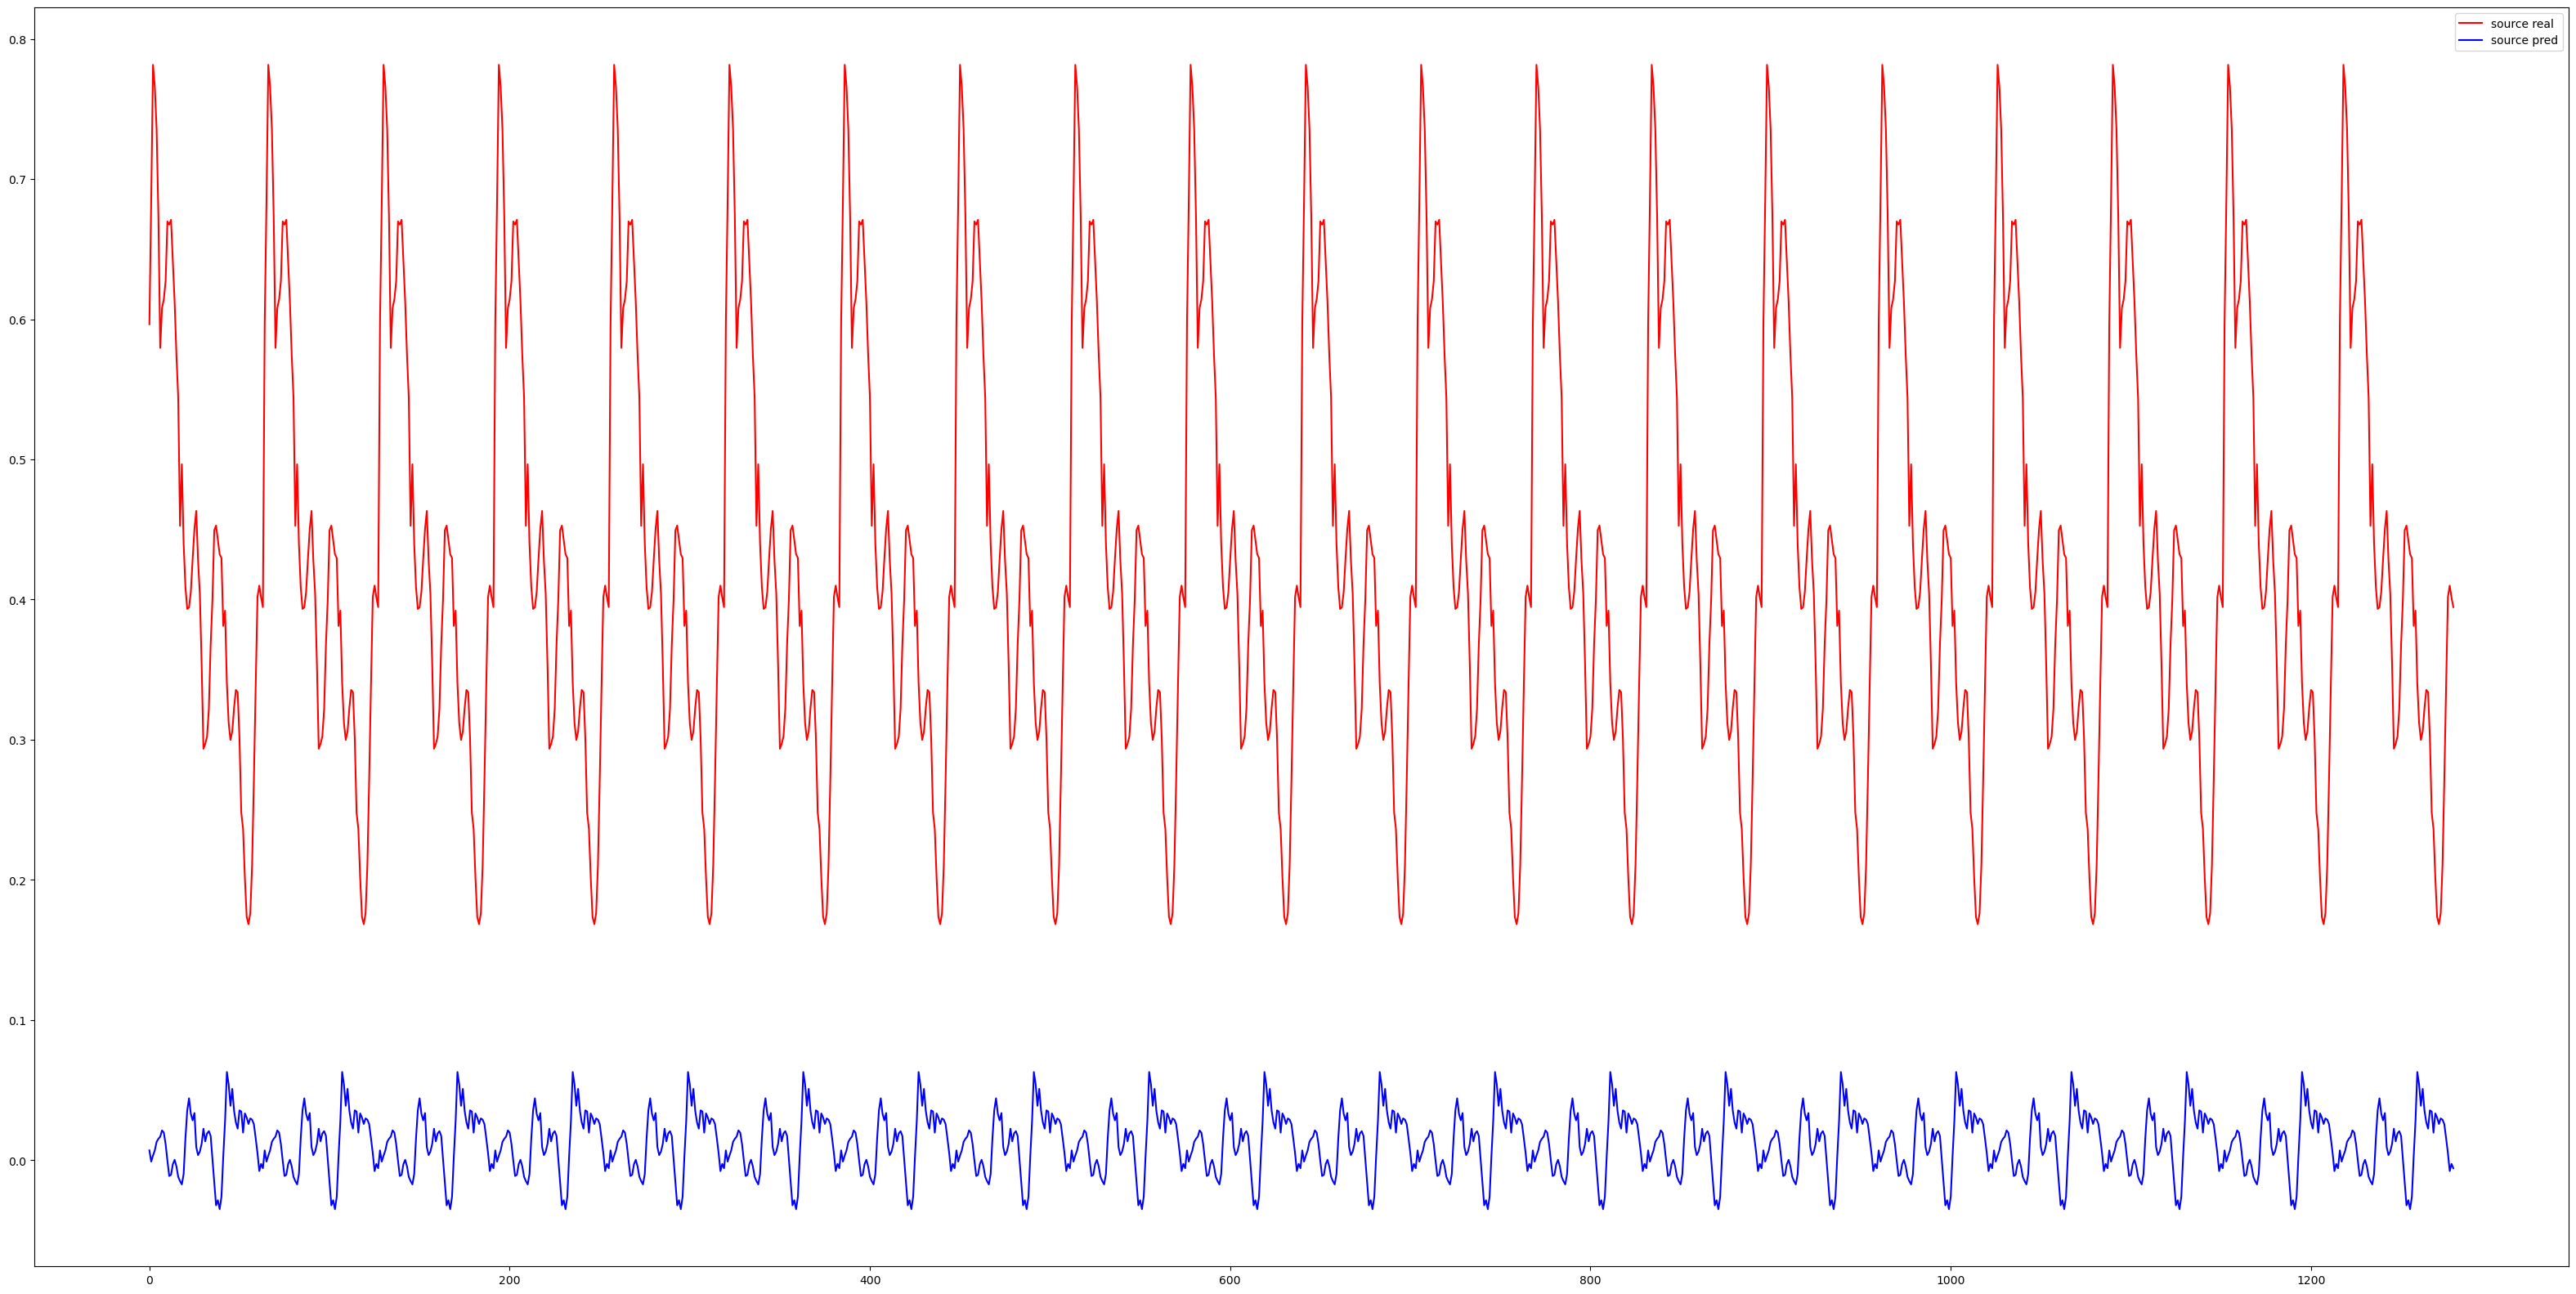

In [21]:
plt.figure(figsize=(40,20))
plt.plot(m_real, color='red', label='source real')
plt.plot(m_predictions, color='blue', label='source pred')
plt.legend()
plt.show()

### Domain Embedding Space 시각화

In [22]:
# 가장 앞 batch의 250개씩의 데이터만 샘플링
source_tsne = DataLoader(nelec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

target_tsne = DataLoader(elec_train,
                        batch_size=1000,
                        shuffle=False,  
                        drop_last=True)

source_tsne2 = next(iter(source_tsne))
target_tsne2 = next(iter(target_tsne))

source_x_TNSE = source_tsne2[0].to(device)
source_y_TNSE = source_tsne2[1].to(device)

target_x_TNSE = target_tsne2[0].to(device)
target_y_TNSE = target_tsne2[1].to(device)

# 학습된 모델의 LSTM 부분만 활용 (100차원 임베딩 벡터를 받아오는 과정)
mnist_vector = model.FeatureLSTM(source_x_TNSE)
svhn_vector = model.FeatureLSTM(target_x_TNSE)

In [23]:
from sklearn.manifold import TSNE

df = pd.DataFrame(np.concatenate([mnist_vector.cpu().detach().numpy(), svhn_vector.cpu().detach().numpy()]))

tsne_np = TSNE(n_components=2).fit_transform(df)
tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

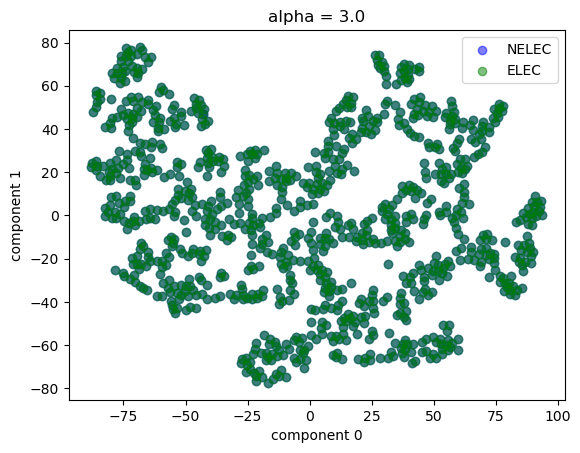

In [26]:
tsne_df_0 = tsne_df.loc[:1000]
tsne_df_1 = tsne_df.loc[1000:]

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='blue', label='NELEC', alpha=0.5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color='green', label='ELEC', alpha=0.5)

plt.title('alpha = '+ str(alpha))
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()